In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor,get_graph_node_names
import os 

### Resnet50 
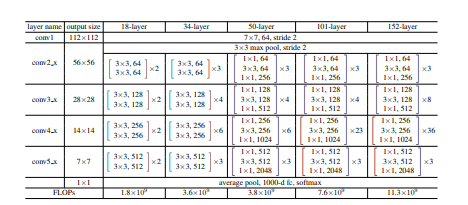

The feature activation outputs by each stage of Resnet50 are called C2, C3, C4, C5
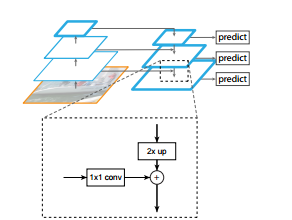

### Typical FPN: 
1. Apply 1x1 conv on C2, C3, C4, C5 -> C2', C3', C4', C5'
2. Upsample the coarsest map C5' by a factor of 2 with nearest neighbour
3. Perform element-wise addition with the map one level down C4' 
4. Repeat steps 2-3 for C(l)', C(l-1)' pairs where l = 4,3
5. Apply 3x3 conv on each merged map to generate final feature maps P2, P3, P4, P5 

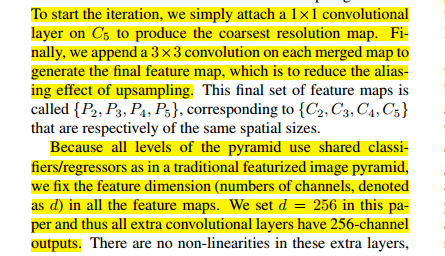

### Note that in Retinanet, some changes are made:
1. C2 is neglected due to high computational power 
2. P6 and P7 are added
    - P6 -> Apply 3x3 conv stride-2 conv on C5
    - P7 -> Apply a ReLu on P6, then apply 3x3 stride-2 conv


In [9]:
class RetinaFPN(nn.Module):
    def __init__(self):
        super(RetinaFPN, self).__init__()
        # top-down layer (C5, C4, C3) each by factor of 2
        self.conv_c5_1x1 = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)
        self.conv_c4_1x1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.conv_c3_1x1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)

        self.conv_c3_3x3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        self.conv_c4_3x3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        self.conv_c5_3x3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)

        self.conv_c6_3x3 = nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=0)
        self.relu_c6 = nn.ReLU()
        self.conv_c7_3x3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        

    def _upsample_add(self, up_map, lateral_map):
        _,_, H,W = lateral_map.size()
        return nn.Upsample(size=[H,W], mode='nearest')(up_map) + lateral_map

    def forward(self, x):
        resnet_model = models.resnet50(pretrained=True)
        return_nodes = {'layer2.3.relu_2': 'layer2','layer3.5.relu_2': 'layer3','layer4.2.relu_2': 'layer4'}
        m = create_feature_extractor(resnet_model, return_nodes=return_nodes)
        backbone_outputs = m(x)
        c3_output = backbone_outputs['layer2']
        c4_output = backbone_outputs['layer3']
        c5_output = backbone_outputs['layer4']

        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p3_output = self.conv_c3_1x1(c3_output)

        # P4 = upsample P5 + 1x1 on C4 
        p4_output =self._upsample_add(p5_output, p4_output)

        # P3 = upsample P4 + 1x1 on C3 
        p3_output = self._upsample_add(p4_output, p3_output)

        # Append 3x3 conv on each merged map 
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)

        # P6 is 3x3 stride-2 conv on C5
        p6_output = self.conv_c6_3x3(c5_output)
        # P7 is 3x3 stride-2 conv on P6
        p7_output = self.conv_c7_3x3(self.relu_c6(p6_output))
        
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [11]:
net = RetinaFPN()
net(torch.randn(1,3,600,600))

(tensor([[[[ 0.5056,  0.3850,  0.3996,  ...,  0.3515,  0.4301,  0.4633],
           [ 0.3792,  0.4155,  0.4709,  ...,  0.2894,  0.2929,  0.3297],
           [ 0.6147,  0.5004,  0.8077,  ...,  0.3201,  0.3933,  0.3147],
           ...,
           [-0.2532, -0.2932, -0.2334,  ...,  0.2954,  0.2669, -0.0233],
           [ 0.0489,  0.1481, -0.1177,  ...,  0.2805,  0.3448,  0.1767],
           [ 0.2389,  0.2845,  0.0888,  ...,  0.2941,  0.4599, -0.0345]],
 
          [[-0.3503, -0.3477, -0.3126,  ..., -0.5805, -0.5864, -0.6433],
           [-0.3760, -0.4517, -0.4217,  ..., -0.5346, -0.6558, -0.6041],
           [-0.1305, -0.1365,  0.1321,  ..., -0.6425, -0.6403, -0.5728],
           ...,
           [-0.8211, -0.8164, -0.6288,  ..., -0.0848, -0.1670, -0.4713],
           [-0.5088, -0.5201, -0.4569,  ..., -0.1328, -0.3992, -0.5497],
           [-0.6551, -0.4628, -0.5550,  ..., -0.1128, -0.3431, -0.6112]],
 
          [[-0.3107, -0.3802, -0.1368,  ...,  0.3649, -0.0295, -0.2565],
           [-